In [1]:
### Library

In [2]:
import re
import os
import json
import csv
import numpy as np
import pandas as pd
from pprint import pprint
import seaborn as sns

# NLTK Stop words
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

# spacy for lemmatization
import spacy

#remove urls, mentions, emojis 
import preprocessor as p

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  
import matplotlib.pyplot as plt

In [3]:
filepath = '/Users/lavine/Desktop/Terriers!/misinformation project/data/data.txt'

In [4]:
pd.set_option('display.max_columns', None)

### Create a dataframe by every columns

In [5]:
#load all the JSON objects in one list as dictionaries
data = []
with open(filepath,'r') as f:
    for line in f:
        data.append(json.loads(line))

### Search bar

In [6]:
#find a twitter's whole dictionary by its id or any other info
#new_result = next((m for m in data if m.get('conversation_id') == '1476916783525370000'), None)
#new_result

 #### Put the original related text data in one list

In [7]:
#Original tweets
lst_text = []

#create lists for id, author id and conversation
lst_id = []
lst_lang = []
lst_author_id = []
lst_conversation_id = []

#lst verified or not, author name and author username
lst_author_verified = []
lst_author_name = []
lst_author_username = []

#list creation time and link
lst_twt_creation_time = []
lst_link = []

for i in data:
    if not 'referenced_tweets' in i:
        lst_text.append(i['text'])
        lst_id.append(i['id'])
        lst_lang.append(i['lang'])
        lst_author_id.append(i['author_id'])
        lst_conversation_id.append(i['conversation_id'])
        lst_author_verified.append(i['author']['verified'])
        lst_author_name.append(i['author']['name'])
        lst_author_username.append(i['author']['username'])
        lst_twt_creation_time.append(i['created_at'])
        #loop the link if this twitter has
        if 'entities' in i and 'urls' in i['entities']:
            lst_link.append(i['entities']['urls'][0]['url'])
        else:
            lst_link.append(None)

#### Put the original tweets in one dataframe

In [8]:
#original tweets
tweets = pd.DataFrame({'text': lst_text,
                       'language': lst_lang,
                       'id': lst_id,
                       'author_id': lst_author_id,
                       'conversation_id': lst_conversation_id,
                       'author_verified': lst_author_verified,
                       'author_name': lst_author_name,
                       'author_username': lst_author_username,
                       'twt_creation_time': lst_twt_creation_time,
                       'urls': lst_link
                      })

 #### Put the reply related text data in one list

In [9]:
#reply tweets
lst_text = []

#create lists for id, author id and conversation
lst_id = []
lst_lang = []
lst_author_id = []
lst_conversation_id = []

#lst verified or not, author name and author username
lst_author_verified = []
lst_author_name = []
lst_author_username = []

#list creation time and link
lst_twt_creation_time = []
lst_link = []

for i in data:
    if 'referenced_tweets' in i and i['referenced_tweets'][0]['type'] == 'replied_to':
        lst_text.append(i['text'])
        lst_id.append(i['id'])
        lst_lang.append(i['lang'])
        lst_author_id.append(i['author_id'])
        lst_conversation_id.append(i['conversation_id'])
        lst_author_verified.append(i['author']['verified'])
        lst_author_name.append(i['author']['name'])
        lst_author_username.append(i['author']['username'])
        lst_twt_creation_time.append(i['created_at'])
        #loop the link if this twitter has
        if 'entities' in i and 'urls' in i['entities']:
            lst_link.append(i['entities']['urls'][0]['url'])
        else:
            lst_link.append(None)

#### Put the reply tweets in one dataframe

In [10]:
#reply tweets
tweets_rly = pd.DataFrame({'rly_text': lst_text,
                       'rly_language': lst_lang,
                       'rly_id': lst_id,
                       'rly_author_id': lst_author_id,
                       'conversation_id': lst_conversation_id,
                       'rly_author_verified': lst_author_verified,
                       'rly_author_name': lst_author_name,
                       'rly_author_username': lst_author_username,
                       'rly_twt_creation_time': lst_twt_creation_time,
                       'rly_urls': lst_link
                      })

 #### Put the retweet related text data in one list

In [11]:
#retweets
lst_text = []

#referenced id
lst_ref_id = []

#create lists for id, author id and conversation
lst_id = []
lst_lang = []
lst_author_id = []
lst_conversation_id = []

#lst verified or not, author name and author username
lst_author_verified = []
lst_author_name = []
lst_author_username = []

#list creation time and link
lst_twt_creation_time = []
lst_link = []

for i in data:
    if 'referenced_tweets' in i and i['referenced_tweets'][0]['type'] == 'retweeted':
        lst_ref_id.append(i['referenced_tweets'][0]['id'])
        lst_text.append(i['text'])
        lst_id.append(i['id'])
        lst_lang.append(i['lang'])
        lst_author_id.append(i['author_id'])
        lst_conversation_id.append(i['conversation_id'])
        lst_author_verified.append(i['author']['verified'])
        lst_author_name.append(i['author']['name'])
        lst_author_username.append(i['author']['username'])
        lst_twt_creation_time.append(i['created_at'])
        #loop the link if this twitter has
        if 'entities' in i and 'urls' in i['entities']:
            lst_link.append(i['entities']['urls'][0]['url'])
        else:
            lst_link.append(None)

#### Put the retweets in one dataframe

In [12]:
#retweets
tweets_rt = pd.DataFrame({'ref_id': lst_ref_id,
                          'rt_text': lst_text,
                       'rt_language': lst_lang,
                       'rt_id': lst_id,
                       'rt_author_id': lst_author_id,
                       'rt_conversation_id': lst_conversation_id,
                       'rt_author_verified': lst_author_verified,
                       'rt_author_name': lst_author_name,
                       'rt_author_username': lst_author_username,
                       'rt_twt_creation_time': lst_twt_creation_time,
                       'rt_urls': lst_link
                      })

In [13]:
df = tweets.merge(tweets_rly,how ='left')
df_1 = df.merge(tweets_rt, left_on = 'id', right_on = 'ref_id', how = 'left')
df_1.describe()

text language  \
count                                              782802   782802   
unique                                              21818       31   
top     I am near speechless. An Exxon official admitt...       en   
freq                                               315744   780233   

                         id author_id      conversation_id author_verified  \
count                782802    782802               782802          782802   
unique                22576     13517                22576               2   
top     1410324793405083661  19055698  1410324793405083661            True   
freq                 315744    317576               315744          641070   

        author_name author_username         twt_creation_time  \
count        782802          782802                    782802   
unique        13398           13517                     22243   
top     Emily Atkin         emorwee  2021-06-30T19:50:07.000Z   
freq         317576          317576                    315744   

                           urls  \
count                    678876   
unique                    19747   
top     https://t.co/Ag0dKyuz6M   
freq                     315788   

                                                 rly_text rly_language  \
count                                              691615       691615   
unique                                                521            5   
top     @emorwee @Marina_Sirtis Exxon knew....Climate ...           en   
freq                                                13728       660011   

                     rly_id rly_author_id rly_author_verified rly_author_name  \
count                691615        691615              691615          691615   
unique                  521           408                   2             408   
top     1412875731122544641      19055698               False     Emily Atkin   
freq                  13728         55067              608784           55067   

       rly_author_username     rly_twt_creation_time                 rly_urls  \
count               691615                    691615                   285932   
unique                 408                       515                      240   
top                emorwee  2021-07-01T18:43:15.000Z  https://t.co/Ag0dKyuz6M   
freq                 55067                     13728                    41184   

                     ref_id  \
count                767004   
unique                 6779   
top     1410324793405083661   
freq                 315744   

                                                  rt_text rt_language  \
count                                              767004      767004   
unique                                               6361          23   
top     RT @emorwee: I am near speechless. An Exxon of...          en   
freq                                               315744      765724   

                      rt_id         rt_author_id   rt_conversation_id  \
count                767004               767004               767004   
unique               173036               106224               173036   
top     1411350380760518659  1279946247399288833  1411350380760518659   
freq                     23                  302                   23   

       rt_author_verified rt_author_name rt_author_username  \
count              767004         767004             767004   
unique                  2          99493             106225   
top                 False              .        seekhopeact   
freq               758827            534                302   

            rt_twt_creation_time                  rt_urls  
count                     767004                    13260  
unique                    160035                     1801  
top     2021-07-01T02:40:38.000Z  https://t.co/2ZSYWK3UMC  
freq                         138                     1332

### Data preprocessing

In [14]:
tweets['hashtag'] = tweets['text'].apply(lambda x: re.findall(r"#(\w+)", x))

In [15]:
#forming a separate column for cleaned tweets
tweets['ctext'] = tweets['text'].apply(lambda x: p.clean(x))

In [16]:
tweets.head(3)

text language  \
0  'We are in a climate emergency'December wildfi...       en   
1  #Oil business knows about the damage that It d...       en   
2  @amywestervelt Your opinion piece concerning c...       en   

                    id            author_id      conversation_id  \
0  1477024401254092800  1009831809855688707  1477024401254092800   
1  1476991564803104776            590788952  1476991564803104776   
2  1476962302159060992  1476958634705780736  1476962302159060992   

   author_verified           author_name  author_username  \
0            False        Vammek Opinion           Vammek   
1            False  Robert Pujol i Vives      rpujolvives   
2            False         Megan Robbins  MeganRo50852817   

          twt_creation_time                     urls             hashtag  \
0  2021-12-31T21:10:33.000Z  https://t.co/sWDkZM4Rvn                  []   
1  2021-12-31T19:00:04.000Z  https://t.co/W7MemjJAA9  [Oil, FossilFuels]   
2  2021-12-31T17:03:48.000Z                     None                  []   

                                               ctext  
0  'We are in a climate emergency'December wildfi...  
1  business knows about the damage that It does, ...  
2  Your opinion piece concerning climate science ...

In [17]:
#convert to list
ctext = tweets['ctext'].tolist()

In [18]:
nctext = tweets['text'].tolist()
tweetid = tweets['id'].tolist()
authorid = tweets['author_id'].tolist()
authorname = tweets['author_name'].tolist()
authorusername = tweets['author_username'].tolist()

In [19]:
# Remove new line characters
ctext = [re.sub('\s+', ' ', sent) for sent in ctext]

<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
/var/folders/kg/0ndh6pln2x7b6rpm16twhvpc0000gn/T/ipykernel_31216/1351202947.py:2: DeprecationWarning: invalid escape sequence \s
  ctext = [re.sub('\s+', ' ', sent) for sent in ctext]


In [20]:
# Remove distracting single quotes
ctext = [re.sub("\'", "", sent) for sent in ctext]

In [21]:
# remove punctuations
ctext = [re.sub(r'[^\w\s]', '', sent) for sent in ctext]

In [22]:
ctext[1:5]

['business knows about the damage that It does but this business is too much easy and lucrative Exxons Plan for Surging Carbon Emissions Revealed in Leaked Documents',
 'Your opinion piece concerning climate science alone motivating people to help create political change on Global Warming policy is Spot On Informing people about the injustices Exxon and Big Oil has perpetrated on us is crucial in inspiring citizens to fight back',
 'Each year the government gives over 15 billion in taxpayerfunded subsidies to fossil fuel corporations who contribute to the climate crisis like Exxon Will you sign this petition to pressure the Senate to END fossil fuel subsidies ',
 'Each year the government gives over 15 billion in taxpayerfunded subsidies to fossil fuel corporations who contribute to the climate crisis like Exxon Will you sign our petition to pressure the Senate to END fossil fuel subsidies ']

### Tokenize words and further clean up text

Tokenize each sentence into a list of words, removing punctuations and unnecessary characters altoghter

In [23]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

tweet_words = list(sent_to_words(ctext))

print(tweet_words[:1])

[['we', 'are', 'in', 'climate', 'wildfires', 'ravage', 'colorado', 'sen', 'manchin', 'your', 'exxon', 'highway', 'bill', 'isnt', 'going', 'save', 'our', 'homes', 'or', 'our', 'lives', 'your', 'greed', 'amp', 'corruption', 'is', 'not', 'only', 'torching', 'our', 'future', 'its', 'burning', 'our', 'communities', 'and', 'destroying', 'lives']]


In [24]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tweet_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tweet_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[tweet_words[0]]])

['we', 'are', 'in', 'climate', 'wildfires', 'ravage', 'colorado', 'sen_manchin', 'your', 'exxon', 'highway', 'bill', 'isnt', 'going', 'save', 'our', 'homes', 'or', 'our', 'lives', 'your', 'greed', 'amp', 'corruption', 'is', 'not', 'only', 'torching', 'our', 'future', 'its', 'burning', 'our', 'communities', 'and', 'destroying', 'lives']


### Remove Stopwords, Make Bigrams and Lemmatize

In [25]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu'])

In [26]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [27]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [28]:
# Remove Stop Words
tweet_words_nostops = remove_stopwords(tweet_words)

In [29]:
# Form Bigrams
tweet_words_bigrams = make_bigrams(tweet_words_nostops)

In [30]:
# Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])# not "en" any more

# Do lemmatization keeping only noun, adj, vb, adv
tweet_lemmatized = lemmatization(tweet_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(tweet_lemmatized[:1])

[['climate', 'wildfire', 'ravage', 'highway', 'bill', 'go', 'save', 'home', 'live', 'greed', 'amp', 'corruption', 'torch', 'future', 'burn', 'community', 'destroy', 'life']]


### Creat the dictionary and the corpus

In [31]:
# Create Dictionary
id2word = corpora.Dictionary(tweet_lemmatized)

# Create Corpus
texts = tweet_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts] 

#Gensim creates a unique id for each word in the document. 
#The produced corpus shown below is a mapping of (word_id, word_frequency(times of occurance)).

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]]


In [32]:
id2word[40]

'inspire'

In [33]:
#If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.
id2word[4]

#input of LDA

'community'

In [34]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('amp', 1),
  ('bill', 1),
  ('burn', 1),
  ('climate', 1),
  ('community', 1),
  ('corruption', 1),
  ('destroy', 1),
  ('future', 1),
  ('go', 1),
  ('greed', 1),
  ('highway', 1),
  ('home', 1),
  ('life', 1),
  ('live', 1),
  ('ravage', 1),
  ('save', 1),
  ('torch', 1),
  ('wildfire', 1)]]

### Building the Topic Model

In [35]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=200,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [36]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.138*"win" + 0.067*"risk" + 0.050*"role" + 0.034*"still" + 0.031*"ad" + '
  '0.028*"impact" + 0.025*"fail" + 0.022*"annual" + 0.022*"grow" + '
  '0.020*"boardroom"'),
 (1,
  '0.155*"energy" + 0.055*"product" + 0.051*"fund" + 0.042*"xom" + '
  '0.040*"include" + 0.031*"state" + 0.024*"sector" + 0.024*"management" + '
  '0.020*"due" + 0.019*"sell"'),
 (2,
  '0.166*"activist" + 0.073*"shareholder" + 0.046*"least" + 0.040*"face" + '
  '0.031*"historic" + 0.019*"decade" + 0.016*"goal" + 0.015*"spend" + '
  '0.014*"investor_oust" + 0.013*"pledge"'),
 (3,
  '0.083*"crisis" + 0.063*"use" + 0.038*"emission" + 0.035*"technology" + '
  '0.027*"back" + 0.026*"good" + 0.024*"large" + 0.024*"support" + 0.024*"cut" '
  '+ 0.022*"could_slow"'),
 (4,
  '0.049*"sue" + 0.043*"action" + 0.039*"engine" + 0.034*"go" + 0.032*"day" + '
  '0.032*"clean" + 0.032*"news" + 0.027*"today" + 0.026*"use" + 0.024*"focus"'),
 (5,
  '0.079*"investor" + 0.036*"giant" + 0.036*"shell" + 0.028*"make" + '
  '0.026*"

### Compute model perplexity and coherence score

In [37]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tweet_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.074989170129179

Coherence Score:  0.3203764653079889


In [38]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: t

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.427426 -0.168003       1        1  35.801768
5     -0.074339  0.253699       2        1  12.911397
7     -0.006318  0.130744       3        1   9.963594
4      0.079403 -0.064699       4        1   9.342286
2     -0.014036  0.113350       5        1   8.514287
3      0.137300 -0.236903       6        1   7.411585
8      0.054631  0.036938       7        1   5.044334
9      0.123504 -0.179390       8        1   4.616462
0      0.061708  0.057717       9        1   3.418980
1      0.065572  0.056548      10        1   2.975307, topic_info=             Term          Freq         Total Category  logprob  loglift
3         climate  15628.000000  15628.000000  Default  30.0000  30.0000
176      activist   3113.000000   3113.000000  Default  29.0000  29.0000
30         change   7260.000000   7260.000000  Default  28.0000  28.0000
195           new   2685.000000   2685.000000  Default  27.0000  27.0000
21          exxon   1976.000000   1976.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
1008     employee     44.631882     45.555523  Topic10  -4.9914   3.4943
2093       debate     43.977377     44.901152  Topic10  -5.0061   3.4940
2577         word     43.626632     44.550367  Topic10  -5.0141   3.4939
1567   capitalism     42.823150     43.746815  Topic10  -5.0327   3.4935
11564     nyc_sue     96.069540     98.657091  Topic10  -4.2247   3.4882

[343 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
861       9  0.986950       accept
1194     10  0.983598       accuse
958       9  0.987401          act
64        4  0.998852       action
3354      9  0.993293     activism
...     ...       ...          ...
1713      3  0.996150  worlds_bigg
786      10  0.995662          xom
63        1  0.960925         year
63        7  0.038437         year
2494     10  0.981885    yesterday

[318 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 8, 5, 3, 4, 9, 10, 1, 2])

# The Following code is still being working on

### Find the optimal number of topics

In [39]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, random_state=500)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [40]:
# May take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=tweet_lemmatized, start=2, limit=20, step=2)

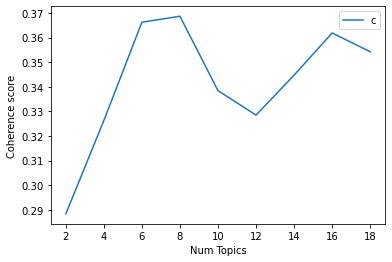

In [41]:
# Show graph
limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [42]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2884
Num Topics = 4  has Coherence Value of 0.3263
Num Topics = 6  has Coherence Value of 0.3662
Num Topics = 8  has Coherence Value of 0.3687
Num Topics = 10  has Coherence Value of 0.3385
Num Topics = 12  has Coherence Value of 0.3285
Num Topics = 14  has Coherence Value of 0.3447
Num Topics = 16  has Coherence Value of 0.3619
Num Topics = 18  has Coherence Value of 0.3543


In [43]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.094*"plan" + 0.091*"exxon" + 0.061*"business" + 0.045*"reveal" + '
  '0.042*"emission" + 0.034*"know" + 0.033*"damage" + 0.029*"evil" + '
  '0.025*"leaked_document" + 0.023*"lucrative"'),
 (1,
  '0.040*"climate" + 0.030*"change" + 0.027*"exxon" + 0.023*"investor" + '
  '0.022*"oil" + 0.021*"board" + 0.015*"activist" + 0.015*"new" + '
  '0.014*"company" + 0.013*"get"'),
 (2,
  '0.090*"climate" + 0.046*"big" + 0.045*"use" + 0.041*"chevron" + '
  '0.037*"crisis" + 0.036*"emission" + 0.036*"downplay" + 0.035*"oil" + '
  '0.033*"shell" + 0.025*"win"'),
 (3,
  '0.117*"fuel" + 0.100*"fossil" + 0.098*"pressure" + 0.034*"corporation" + '
  '0.033*"climate" + 0.030*"subsidy" + 0.029*"petition" + 0.025*"end" + '
  '0.023*"year" + 0.018*"ambitious"'),
 (4,
  '0.094*"climate" + 0.027*"change" + 0.025*"lawsuit" + 0.021*"worlds_bigg" + '
  '0.019*"keep" + 0.018*"future" + 0.017*"go" + 0.017*"dark" + '
  '0.017*"climatechange" + 0.014*"accountable"'),
 (5,
  '0.081*"oil" + 0.064*"climate" + 

In [44]:
# Visualize the optimal topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
vis

/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.144801  0.056945       1        1  15.331453
5     -0.174660  0.002711       2        1  14.925010
6     -0.052341  0.016776       3        1  11.831433
7     -0.094008 -0.022878       4        1  11.255240
9     -0.077522 -0.050878       5        1   9.945864
8     -0.017451  0.059325       6        1   8.978759
2     -0.018514  0.019075       7        1   8.550513
4      0.044502 -0.057980       8        1   7.622634
3      0.241270 -0.272718       9        1   7.002500
0      0.293525  0.249620      10        1   4.556594, topic_info=         Term         Freq         Total Category  logprob  loglift
56       fuel  2051.000000   2051.000000  Default  30.0000  30.0000
59   pressure  1554.000000   1554.000000  Default  29.0000  29.0000
55     fossil  1752.000000   1752.000000  Default  28.0000  28.0000
21      exxon  2382.000000   2382.000000  Default  27.0000  27.0000
25       plan  1075.000000   1075.000000  Default  26.0000  26.0000
..        ...          ...           ...      ...      ...      ...
74    senator    64.352210    123.489447  Topic10  -5.0517   2.4368
379      full    63.794992    171.748584  Topic10  -5.0604   2.0982
351     still    74.850928    356.081989  Topic10  -4.9005   1.5289
3     climate   174.508363  15177.619075  Topic10  -4.0541  -1.3770
15       save    49.838428    103.605567  Topic10  -5.3072   2.3568

[633 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1636      3  0.828705       accord
1636      7  0.121448       accord
1636      8  0.050008       accord
1759      1  0.088821  accountable
1759      3  0.059214  accountable
...     ...       ...          ...
63        7  0.008478         year
63        8  0.003179         year
63        9  0.381492         year
63       10  0.003179         year
2240      2  0.970162    york_time

[1568 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 7, 8, 10, 9, 3, 5, 4, 1])

In [45]:
len(nctext)

22576

In [46]:
len(authorid)

22576

In [47]:
len(lst_author_id)


nctext = tweets['text'].tolist()
tweetid = tweets['id'].tolist()
authorid = tweets['author_id'].tolist()

### Finding the dominant topic in each sentence

In [48]:
def format_topics_sentences(ldamodel=lda_model,
                            corpus=corpus,
                            texts=nctext,
                            tweet_id=tweetid,
                            author_id=authorid,
                            author_name=authorname,
                            author_username=authorusername):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    TweetId = pd.Series(tweet_id)
    AuthorId = pd.Series(author_id)
    AuthorName = pd.Series(author_name)
    AuthorUseranme = pd.Series(author_username)
    
    sent_topics_df = pd.concat([sent_topics_df, contents, TweetId, AuthorId, AuthorName, AuthorUseranme], axis=1)
    #sent_topics_df = pd.concat([sent_topics_df, TweetId], axis=1)
    #sent_topics_df = pd.concat([sent_topics_df, AuthorId], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model,
                                                  corpus=corpus,
                                                  texts=nctext,
                                                  tweet_id=tweetid,
                                                  author_id=authorid,
                                                  author_name=authorname,
                                                  author_username=authorusername)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 
                             'Keywords', 'Text', 'TweetId', 'AuthorId', 'AuthorName','AuthorUsername']

# Show
df_dominant_topic.head()

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             4.0              0.3391   
1            1             0.0              0.9182   
2            2             8.0              0.7088   
3            3             3.0              0.9471   
4            4             3.0              0.9471   

                                            Keywords  \
0  climate, change, lawsuit, worlds_bigg, keep, f...   
1  plan, exxon, business, reveal, emission, know,...   
2  climate, change, force, case, time, exxon, bus...   
3  fuel, fossil, pressure, corporation, climate, ...   
4  fuel, fossil, pressure, corporation, climate, ...   

                                                Text              TweetId  \
0  'We are in a climate emergency'December wildfi...  1477024401254092800   
1  #Oil business knows about the damage that It d...  1476991564803104776   
2  @amywestervelt Your opinion piece concerning c...  1476962302159060992   
3  Each year, the government gives over $15 billi...  1476954565450903553   
4  Each year, the government gives over $15 billi...  1476922966893948928   

              AuthorId            AuthorName   AuthorUsername  
0  1009831809855688707        Vammek Opinion           Vammek  
1            590788952  Robert Pujol i Vives      rpujolvives  
2  1476958634705780736         Megan Robbins  MeganRo50852817  
3             47878087         Jennifer Hall     JDHall_35402  
4  1450838788037496836          Dennis Landi     DennisLandi2

In [49]:

url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

df_dominant_topic['urls'] = df_dominant_topic['Text'].apply(lambda x: re.findall(url_regex, x))

df_url_lst = df_dominant_topic.filter(['Dominant_Topic','TweetId','AuthorId','AuthorName','AuthorUsername','urls'], axis=1)

df_url_lst.head(10)

<>:1: DeprecationWarning: invalid escape sequence \(
<>:1: DeprecationWarning: invalid escape sequence \(
/var/folders/kg/0ndh6pln2x7b6rpm16twhvpc0000gn/T/ipykernel_31216/1398678993.py:1: DeprecationWarning: invalid escape sequence \(
  url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'


Dominant_Topic              TweetId             AuthorId  \
0             4.0  1477024401254092800  1009831809855688707   
1             0.0  1476991564803104776            590788952   
2             8.0  1476962302159060992  1476958634705780736   
3             3.0  1476954565450903553             47878087   
4             3.0  1476922966893948928  1450838788037496836   
5             0.0  1476916783525371911           2843451077   
6             3.0  1476798432949858306           1269149246   
7             1.0  1476748809485045783             15729844   
8             4.0  1476732535572889601            203414131   
9             9.0  1476720659006820354  1455307963078352898   

             AuthorName   AuthorUsername  \
0        Vammek Opinion           Vammek   
1  Robert Pujol i Vives      rpujolvives   
2         Megan Robbins  MeganRo50852817   
3         Jennifer Hall     JDHall_35402   
4          Dennis Landi     DennisLandi2   
5              Bob Hill     bobhillbrain   
6          SAVE AMERICA  vietthanhsports   
7            Max Berger        maxberger   
8                   Jon       ObiWan0001   
9           John Harman    FanOfKurzweil   

                                                urls  
0                          [https://t.co/sWDkZM4Rvn]  
1  [https://t.co/W7MemjJAA9, https://t.co/RFX8meY...  
2                                                 []  
3                         [https://t.co/2A7wLyid3X?]  
4                         [https://t.co/OD7YqPO5SP?]  
5  [https://t.co/o4xvt3yxVm, https://t.co/CGRbN8j...  
6                         [https://t.co/SAKgz7OEZy?]  
7                                                 []  
8                          [https://t.co/ppdezrIN74]  
9                                                 []

In [50]:
#remove rows that don't contain urls
df_url_lst_only = df_url_lst[df_url_lst['urls'].map(lambda d: len(d)) > 0]

df_url_lst_only.head(10)

Dominant_Topic              TweetId             AuthorId  \
0              4.0  1477024401254092800  1009831809855688707   
1              0.0  1476991564803104776            590788952   
3              3.0  1476954565450903553             47878087   
4              3.0  1476922966893948928  1450838788037496836   
5              0.0  1476916783525371911           2843451077   
6              3.0  1476798432949858306           1269149246   
8              4.0  1476732535572889601            203414131   
10             2.0  1476719254833618945  1006146920119750657   
12             3.0  1476687897466130434           1618504489   
13             0.0  1476675758357729292           2843451077   

              AuthorName   AuthorUsername  \
0         Vammek Opinion           Vammek   
1   Robert Pujol i Vives      rpujolvives   
3          Jennifer Hall     JDHall_35402   
4           Dennis Landi     DennisLandi2   
5               Bob Hill     bobhillbrain   
6           SAVE AMERICA  vietthanhsports   
8                    Jon       ObiWan0001   
10                Connor       connorfx76   
12                Nelson      NelsonAPike   
13              Bob Hill     bobhillbrain   

                                                 urls  
0                           [https://t.co/sWDkZM4Rvn]  
1   [https://t.co/W7MemjJAA9, https://t.co/RFX8meY...  
3                          [https://t.co/2A7wLyid3X?]  
4                          [https://t.co/OD7YqPO5SP?]  
5   [https://t.co/o4xvt3yxVm, https://t.co/CGRbN8j...  
6                          [https://t.co/SAKgz7OEZy?]  
8                           [https://t.co/ppdezrIN74]  
10                          [https://t.co/Z46zJmZspE]  
12                         [https://t.co/1Zk40ByoVK?]  
13  [https://t.co/o4xvt3yxVm, https://t.co/CGRbN8j...

In [51]:
df_url_lst_only.shape

(21058, 6)

In [52]:
#creat multiple rows for the tweet that has multiple urls
df_url = df_url_lst_only.set_index(['Dominant_Topic','TweetId','AuthorId','AuthorName','AuthorUsername'])['urls'].apply(pd.Series).stack()
df_url = df_url.reset_index()
df_url.columns = ['Topic','TweetId','AuthorId','AuthorName','AuthorUsername','#urls','urls']
df_url.head()

Topic              TweetId             AuthorId            AuthorName  \
0    4.0  1477024401254092800  1009831809855688707        Vammek Opinion   
1    0.0  1476991564803104776            590788952  Robert Pujol i Vives   
2    0.0  1476991564803104776            590788952  Robert Pujol i Vives   
3    3.0  1476954565450903553             47878087         Jennifer Hall   
4    3.0  1476922966893948928  1450838788037496836          Dennis Landi   

  AuthorUsername  #urls                      urls  
0         Vammek      0   https://t.co/sWDkZM4Rvn  
1    rpujolvives      0   https://t.co/W7MemjJAA9  
2    rpujolvives      1   https://t.co/RFX8meYv11  
3   JDHall_35402      0  https://t.co/2A7wLyid3X?  
4   DennisLandi2      0  https://t.co/OD7YqPO5SP?

In [53]:
df_twid_text = df_dominant_topic[["TweetId", "Text"]]
df_url = df_url.merge(df_twid_text, on='TweetId', how='left')

#export df_url_lst to csv
os.makedirs('/Users/lavine/Desktop/Terriers!/misinformation project/github/Climate-Change-Misinformation-project', exist_ok=True)  
df_url.to_csv('/Users/lavine/Desktop/Terriers!/misinformation project/github/Climate-Change-Misinformation-project/each_topic_urls.csv')

In [54]:
df_url.shape

(23043, 8)

In [55]:
for i in range (10):
    print(len(df_url[df_url['Topic'] == i]))

1893
3530
2370
712
1909
3919
2913
2319
1590
1888


In [56]:
df_url[df_url['Topic'] == 1]

Topic              TweetId             AuthorId  \
40       1.0  1476557447569367043           2733194937   
48       1.0  1476281548102115328  1253489331320258568   
54       1.0  1476147951940550658   871365868701315072   
56       1.0  1476095348569296898  1111820543282413568   
57       1.0  1476084546844176387           1901515206   
...      ...                  ...                  ...   
23027    1.0  1345741484054732800   876181612790153216   
23030    1.0  1345721198609620992           2188942099   
23031    1.0  1345710040150261765            716818400   
23034    1.0  1345496855875100673   783719151684685824   
23038    1.0  1345296761678512128  1014536032367198208   

                      AuthorName   AuthorUsername  #urls  \
40            Ritchie Stirling🌎🌊       rstirling6      0   
48                  Anne Stanton  TalesOfStrength      0   
54                   Neil Salter      NeilSalter4      0   
56       Franklin w. Russell🚗🔥🌎🕊        FrklnwRu1      0   
57                   Ian Goldman     iangoldmansa      0   
...                          ...              ...    ...   
23027                 Rune Røkke       RuneRoekke      0   
23030              patrick smith  cpatrickpatrick      0   
23031  Dr. Laurie Donahue-Hjelle   Ldonahuehjelle      0   
23034            Bloomberg Green          climate      0   
23038               Chris Rathke      solarnomics      0   

                          urls  \
40     https://t.co/oPYcHQdwGm   
48     https://t.co/Xq2mxSYacS   
54     https://t.co/5Aezsc4Ewq   
56     https://t.co/HcuEBUEfQ1   
57     https://t.co/KHAmM3UHkb   
...                        ...   
23027  https://t.co/BTvyOCAa4i   
23030  https://t.co/TjNSovxiM0   
23031  https://t.co/KvcebC3ObI   
23034  https://t.co/NU8TSWIedT   
23038  https://t.co/dcsTiOqlvy   

                                                    Text  
40     "In 1973, Exxon secured a patent for an oil ta...  
48     "Exxon secured a patent for an oil tanker that...  
54     "Exxon secured a patent for an oil tanker that...  
56     Climate Change is not OUR fault. Climate Chang...  
57     In 1973, Exxon patented an oil tanker to navig...  
...                                                  ...  
23027  Exxon Mobil is targeted by activist investors,...  
23030  Leaked documents reveal Exxon's secret project...  
23031  People who wouldn’t strike to get rid of trump...  
23034  NextEra, the world’s biggest provider of wind ...  
23038  Nonsense! Exxon's dismissal of  carbon-capture...  

[3530 rows x 8 columns]

In [57]:
os.makedirs('/Users/lavine/Desktop/Terriers!/misinformation project/github/Climate-Change-Misinformation-project', exist_ok=True)  

#for i in range(10):

for i in range(10):
    topic = df_url[df_url['Topic'] == i].pivot_table(columns=['urls'], aggfunc='size').sort_values(ascending=False).to_frame()
    topic.to_csv('/Users/lavine/Desktop/Terriers!/misinformation project/github/Climate-Change-Misinformation-project/' + 'topic'+ str(i) + '.csv') 


#export df_url_lst to csv
os.makedirs('/Users/lavine/Desktop/Terriers!/misinformation project/github/Climate-Change-Misinformation-project', exist_ok=True)  
df_url.to_csv('/Users/lavine/Desktop/Terriers!/misinformation project/github/Climate-Change-Misinformation-project/links_rank.csv')  

### Find the most representative document for each topic

In [59]:
df_topic_sents_keywords = df_topic_sents_keywords.iloc[: , :-4]

In [60]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.9219   
1        1.0              0.9591   
2        2.0              0.9500   
3        3.0              0.9526   
4        4.0              0.9437   
5        5.0              0.9535   
6        6.0              0.9550   
7        7.0              0.9470   
8        8.0              0.9501   
9        9.0              0.9566   

                                            Keywords  \
0  plan, exxon, business, reveal, emission, know,...   
1  climate, change, exxon, investor, oil, board, ...   
2  climate, big, use, chevron, crisis, emission, ...   
3  fuel, fossil, pressure, corporation, climate, ...   
4  climate, change, lawsuit, worlds_bigg, keep, f...   
5  oil, climate, activist, board, big, seat, comp...   
6  climate, push, lobbyist, video, catch, company...   
7  climate, change, say, know, engine, least, fig...   
8  climate, change, force, case, time, exxon, bus...   
9  climate, change, technology, court, new, could...   

                                                Text  
0  "Wir haben bei Exxon 1980 vorhergesagt, wie ho...  
1  Just imagine a world in which this $174 billio...  
2  A US small-town mayor sued the oil industry. T...  
3  Each year, the government gives over $15 billi...  
4  How a poor country imperiled by climate change...  
5  Exxon Mobil Corp on Wednesday said for the fir...  
6  I can’t believe the first ad I heard today on ...  
7  "Total was also aware of global warming’s cata...  
8  @Sen_JoeManchin \n\nWEST VIRGINIA - MANCHIN TO...  
9  Oil companies pay fines instead of fixing issu...

### Topic distribution across documents

In [61]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(10)

Dominant_Topic                                     Topic_Keywords  \
0.0             4.0  climate, change, lawsuit, worlds_bigg, keep, f...   
1.0             0.0  plan, exxon, business, reveal, emission, know,...   
2.0             8.0  climate, change, force, case, time, exxon, bus...   
3.0             3.0  fuel, fossil, pressure, corporation, climate, ...   
4.0             3.0  fuel, fossil, pressure, corporation, climate, ...   
5.0             0.0  plan, exxon, business, reveal, emission, know,...   
6.0             3.0  fuel, fossil, pressure, corporation, climate, ...   
7.0             1.0  climate, change, exxon, investor, oil, board, ...   
8.0             4.0  climate, change, lawsuit, worlds_bigg, keep, f...   
9.0             9.0  climate, change, technology, court, new, could...   

     Num_Documents  Perc_Documents  
0.0         1937.0          0.0858  
1.0         3557.0          0.1576  
2.0         2208.0          0.0978  
3.0          715.0          0.0317  
4.0         1835.0          0.0813  
5.0         3635.0          0.1610  
6.0         2780.0          0.1231  
7.0         2440.0          0.1081  
8.0         1637.0          0.0725  
9.0         1832.0          0.0811